# Transformer Architecture Revisited


In this scenario, you will implement an improved decoder-only Transformer architecture and train the model using the language modeling objective.

# Architecture
This part of the notebook concerns the implementation of the Transformer architecture.
You can read more about the Vanilla Transformer in the [original paper](https://arxiv.org/abs/1706.03762).
You will implement two improvements to the Vanilla architecture - [SwiGLU](https://arxiv.org/abs/2002.05202v1) and [Differential Attention](https://arxiv.org/abs/2410.05258)

## Brief Description

### The Input

**Input to the transformer model is a sequence of tokens.   
The length of the input sequence is bounded by model context size.**


**Tokens** can correspond to individual characters, words, or short character sequences.  
Tokens are usually represented as natural numbers.  
The **tokenizer** is a program that converts text to a sequence of tokens.  
For example, consider the word `habitat` if we apply a GPT-3 tokenizer to it, then we will get a sequence of three tokens `[5976, 270, 265]` that corresponds to `["hab", "it", "at"]`.  
The common approach is to tokenize the text using around 128k different tokens.  
You can read more about tokenizers [here](https://huggingface.co/docs/transformers/tokenizer_summary).


### The Output
For each input token, the transformer model outputs a probability distribution on the next token given the previous tokens in the context.  
For example, if the model inputs three tokens `["hab", "it", "at"]` for the token `it` the model will output probability distribution $\mathbb{P}(t_3 | t_1= hab, t_2=it)$.  
In general if we denote the function induced by the transformer network as $T$ and tokens as $t_i$ for $i\in\{1\dots n\}$, then $T(t_i)=\mathbb{P}(t_i|t_{i-1}\dots t_1)$, where the probability $\mathbb{P}$ is the distribution that the training data was sampled from.




### Transformer Processing Pipeline - Overview
Let's look at the image below.  

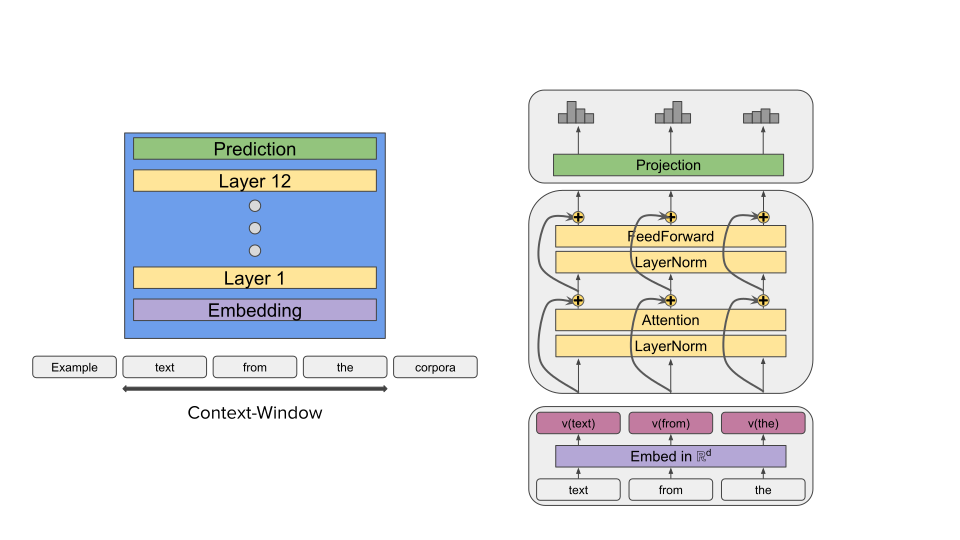



Processing in the Transformer model starts with converting each input token to a vector of real numbers using the Embedding layer.  
The Embedding layer stores a matrix of shape `(num_tokens, hidden_dim)` where each row contains an embedding vector corresponding to a particular token.  
Initially, these vectors are random, but as the model trains it learns to associate `appropriate meaning` with each token.


After the embedding, the tokens (now vectors) are passed through the Transformer layers.
In each layer, two major sublayers are used
* Attention
* FeedForward

Input to those two sublayers is normalized, and a skip connection is applied. This skip connection takes the input to the sublayer before normalization
and adds it to the result of the sublayer.  

Attention allows each token (now represented as a vector) to look at the preceding tokens.
FeedForward is usually implemented as a variant of MLP and allows the model to transform the hidden representation of each token.


After processing, we linearly project each token to a vector of length `num_tokens` and use softmax to generate probability distribution on the next token.

Note that each token (or the corresponding vector) is processed by each layer independently except for the Attention layer, where tokens can "look" at other tokens.

# Note on the implementation

The implementation below will follow a pattern: first you implement a functional version of some layer (e.g. swiglu_feedforward) and later wrap it around a corresponding class (e.g. SwiGLUFeedForward). The functional version should receive all the matrices as function variables and perform the computation, and the class version should hold all the relevant parameters and  pass them to the functional version is the `forward` call. Do not modify the signatures of functional parts or `__init__` functions in classes, as it might clash with the tests.

## SwiGLUFeedForward (1p)
Lets start with implementing a [SwiGLU](https://arxiv.org/abs/2002.05202v1) feedforward layer.
Compared to the usual version of FeedForward, this version uses 3 Linear layers: $W_1, V: \mathbb{R}^{d_{hidden}} \rightarrow \mathbb{R}^{d_{inner}}$ and $W_2: \mathbb{R}^{d_{inner}} \rightarrow \mathbb{R}^{d_{hidden}}$.
The output of the layer on the input $x$ is produced in the following manner

$h_1 = W_1(x)$

$h_v = V(x)$

$h_2 = \text{SiLU}(h_1) \cdot h_v$

$\text{result} = W_2 (h_2)$

Where $\text{SiLU}(x) = \sigma(x)\cdot x$ (in the paper, SwiGLU uses Swish with $\beta = 1$, which is called SiLU in pytorch)

In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from typing import List, Tuple, Any, Optional

HiddenT = torch.Tensor # Tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

def swi_glu_feedforward(x: HiddenT, w1: Linear, v: Linear, w2: Linear) -> HiddenT:
    """
    Implement the computation of the SwiGLU feedforward layer.
    """
    # [BATCH, SEQ_LEN, HIDDEN_DIM]
    assert len(x.shape) == 3

    ### YOUR CODE STARTS ###
    silu = torch.nn.SiLU()
    result = w2(silu(w1(x)) * v(x))
    ###  YOUR CODE ENDS  ###

    # [BATCH, SEQ_LEN, HIDDEN_DIM]
    assert len(result.shape) == 3
    return result

class SwiGLUFeedForward(torch.nn.Module):
    """
    Inputs a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    and processes it as follows:
    * project linearly from hidden_dim to inner_dim
    * apply activation function (GELU)
    * project linearly from inner_dim to hidden_dim
    """

    def __init__(self, hidden_dim: int, inner_dim: int) -> None:
        super().__init__()

        ### YOUR CODE STARTS ###
        self.w1 = Linear(in_features=hidden_dim,
                         out_features=inner_dim)
        self.v = Linear(in_features=hidden_dim,
                         out_features=inner_dim)
        self.w2 = Linear(in_features=inner_dim,
                         out_features=hidden_dim)
        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> HiddenT:
        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(x.shape) == 3

        ### YOUR CODE STARTS ###
        result = swi_glu_feedforward(x, self.w1, self.v, self.w2)
        ###  YOUR CODE ENDS  ###

        return result


##### TESTS START #####


def test_swiglu(x, w1, v, w2, expected):

    out = swi_glu_feedforward(x, w1, v, w2)
    assert torch.allclose(out, expected, atol=1e-4)

def test_swiglu_1():
    torch.manual_seed(0)
    batch_size = 2
    seq_len = 3
    hidden_dim = 4
    inner_dim = 5
    x = torch.randn(batch_size, seq_len, hidden_dim)
    w1 = Linear(hidden_dim, inner_dim)
    v = Linear(hidden_dim, inner_dim)
    w2 = Linear(inner_dim, hidden_dim)
    expected = torch.tensor(
        [[[ 0.1177,  0.4688, -0.0937,  0.3353],
         [-0.2425,  0.2179, -0.6366,  0.3862],
         [-0.2348,  0.3322, -0.2791,  0.3969]],

        [[-0.1819,  0.2574, -0.2657,  0.4056],
         [-0.3076,  0.4647, -0.2785,  0.4031],
         [-0.2179,  0.3847, -0.8161,  0.3436]]])
    test_swiglu(x, w1, v, w2, expected)

test_swiglu_1()


#####  TESTS END  #####

### RMSNorm

RMSNorm is a type of layer normalization (similar to LayerNorm or BatchNorm), which recently became the default normalization in bigger transformers. You can find the exact formula [here](https://pytorch.org/docs/stable/generated/torch.nn.modules.normalization.RMSNorm.html). Here, you should implement it yourself, without use of torch.nn.RMSNorm. Remember that $\gamma$ should be initialized to $1$.

In [2]:
def rms_norm(x: torch.Tensor, gamma: torch.Tensor, eps: float) -> torch.Tensor:
    """
    Implement the computation of the RMSNorm layer.
    Remember to make it work for any x, not only for 3D tensors.
    The norm should be computed along the last dimension.
    """

    ### YOUR CODE STARTS ###
    rms_sqrt = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + eps)
    result = (x / rms_sqrt) * gamma
    ###  YOUR CODE ENDS  ###

    return result

class RMSNorm(torch.nn.Module):
    def __init__(self, hidden_dim, eps=1e-05) -> None:
        super().__init__()

        self.hidden_dim = hidden_dim
        self.eps = eps

        ### YOUR CODE STARTS ###
        self.gamma = torch.nn.Parameter(torch.ones(hidden_dim))
        ### YOUR CODE ENDS ###

    def forward(self, x: torch.Tensor) -> HiddenT:

        ### YOUR CODE STARTS ###
        result = rms_norm(x, self.gamma, self.eps)
        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape
        return result


##### TESTS START #####

def test_rms_norm(x, gamma, eps, expected):
    out = rms_norm(x, gamma, eps)
    assert torch.allclose(out, expected, atol=1e-4)

def test_rms_norm_1():
    torch.manual_seed(0)
    x = torch.randn(2, 3, 4)
    gamma = torch.tensor([1, 2, 3, 4])
    eps = 1e-5
    expected = torch.tensor(
        [[[-1.3346, -2.7321, -0.8911, -2.0573],
         [ 0.7064,  1.1520, -0.7891, -7.0426],
         [ 0.6044, -0.4073,  5.5925,  1.3742]],

        [[ 0.3664,  3.8499, -0.9476, -0.9828],
         [ 0.7323,  1.9789,  4.7271,  0.1689],
         [ 0.4803, -0.6416, -1.9608, -7.1991]]])
    test_rms_norm(x, gamma, eps, expected)

test_rms_norm_1()

#####  TESTS END  #####

## Attention

First, let's implement a Multihead attention mechanism.
The computation goes as follows.
* QKV computation:
    * The input $x$ of shape `(batch_size, sequence_lenght, hidden_dim)` (`(b, l, hid)` for short) gets multiplied by 3 weights: $W_K, W_Q, W_V$ to get matrices $Q, K, V$, each of size `(b, l, num_heads * head_dim)` (`(b, l, n_h * head)`). Often `n_h * head == hid`.
    * The $Q, K, V$ gets resized to `(b, l, n_h, head)` and then the dimensions get permuted to match `(b, n_h, l, head)`
* Causal Self-attention (shapes in paranthesis):
    * Attention pre-activation matrix $A'$ is calculated as $A' = QK^T$ `(b, n_h, l, l)`
    * $A'$ is normalized $A' = A' / \sqrt{head}$, this is to get entries of $A'$ with variance $1$ at initialization.
    * Causal mask is added $A' = A' + M$, `(b, n_h, l, l)` where $M$ is a causal mask, with 0 on and below main diagonal and $-\infty$ above.
    * Attention matrix $A$ is calculated $A = \text{softmax}(A')$ `(b, n_h, l, l)` , where `softmax` is taken row-wise (last dimension). Together with the step before it produces $A$ that is lower triangular and whose rows sum up to 1.
    * Per-head output gets calculated by $O' = AV$ `(b, n_h, l, head)`
* Ouput
    * Per-head outputs get concatenated by permuting dimensions of $O'$ to be `(b, l, n_h, head)` and then resizing to `(b, l, n_h * head)`.
    * $O'$ get's multiplied by output weight $W_O$ of size `(n_h * head, hid)` to get the output of the attention $O = W_O O'$ `(b, l, hid)`


### Attention - Create Q,K,V (1p)
Follow the docstrings and fill in the code below.

In [16]:
AttentionT = torch.Tensor  # torch tensor of shape [BATCH, NUM_HEADS, SEQ_LEN, HEAD_DIM]

def attention_create_qkv(x: HiddenT, w_q: Linear, w_k: Linear, w_v: Linear, n_heads: int, head_dim: int) -> Tuple[AttentionT, AttentionT, AttentionT]:
    """
    Given a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    uses linear projections to create three tensors
    Query, Key and Value.
    Each of the created tensors has shape [BATCH, NUM_HEADS, SEQ_LEN, HEAD_DIM].
    """

    assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    batch_size, seq_len, _ = x.shape

    ### YOUR CODE STARTS ###
    q = w_q(x).reshape(batch_size, seq_len, n_heads, head_dim).permute(0, 2, 1, 3)
    k = w_k(x).reshape(batch_size, seq_len, n_heads, head_dim).permute(0, 2, 1, 3)
    v = w_v(x).reshape(batch_size, seq_len, n_heads, head_dim).permute(0, 2, 1, 3)
    ###  YOUR CODE ENDS  ###

    assert q.shape == k.shape == v.shape == (batch_size, n_heads, seq_len, head_dim)

    return q, k, v

class AttentionCreateQKV(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    uses linear projections to create three tensors
    Query, Key and Value.
    Each of the created tensors has shape [BATCH, NUM_HEADS, SEQ_LEN, HEAD_DIM]."""

    def __init__(self, hidden_dim: int, num_heads: int, head_dim: int) -> None:
        super().__init__()
        assert hidden_dim % num_heads == 0
        self.head_dim = head_dim
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###
        self.w_q = Linear(hidden_dim, head_dim * num_heads, bias=False)
        self.w_k = Linear(hidden_dim, head_dim * num_heads, bias=False)
        self.w_v = Linear(hidden_dim, head_dim * num_heads, bias=False)
        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> Tuple[AttentionT, AttentionT, AttentionT]:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###
        q, k, v = attention_create_qkv(x=x,
                                       w_q=self.w_q,
                                       w_k=self.w_k,
                                       w_v=self.w_v,
                                       n_heads=self.num_heads,
                                       head_dim=self.head_dim)
        ###  YOUR CODE ENDS  ###

        assert q.shape == k.shape == v.shape == (x.shape[0], self.num_heads, x.shape[1], self.head_dim)

        return q, k, v


##### TESTS START #####

def test_attention_create_qkv(x, w_q, w_k, w_v, n_heads, head_dim, expected):
    q, k, v = attention_create_qkv(x, w_q, w_k, w_v, n_heads, head_dim)
    assert torch.allclose(q, expected[0], atol=1e-4)
    assert torch.allclose(k, expected[1], atol=1e-4)
    assert torch.allclose(v, expected[2], atol=1e-4)

def test_attention_create_qkv_1():
    torch.manual_seed(0)
    batch_size = 2
    seq_len = 3
    hidden_dim = 4
    num_heads = 2
    head_dim = 2
    x = torch.randn(batch_size, seq_len, hidden_dim)
    w_q = Linear(hidden_dim, num_heads * head_dim, bias=False)
    w_k = Linear(hidden_dim, num_heads * head_dim, bias=False)
    w_v = Linear(hidden_dim, num_heads * head_dim, bias=False)

    expected = (
        torch.tensor(
        [[[[ 0.4472,  0.4975],
          [ 0.8057, -1.2048],
          [ 0.0507,  0.4050]],

         [[-0.0254, -0.2575],
          [-1.3531,  0.7319],
          [ 0.4929,  0.4879]]],


        [[[-0.1798, -0.3635],
          [-0.1537, -0.0129],
          [ 1.1322, -1.0612]],

         [[-0.1540,  0.0769],
          [ 0.4385,  0.9263],
          [-1.5498,  0.4946]]]]),
        torch.tensor(
        [[[[ 0.5407, -0.4777],
          [ 0.4667,  0.1052],
          [-0.4643, -0.3132]],

         [[-0.2914, -0.7264],
          [-0.0618,  1.1048],
          [ 0.1968, -0.5355]]],


        [[[-0.2449,  0.2391],
          [-1.1099, -0.1217],
          [ 1.1073, -0.0439]],

         [[-0.0252,  0.5472],
          [ 0.2208,  0.1111],
          [-0.0887,  0.7420]]]]
        ),
        torch.tensor(
        [[[[-0.9991,  0.5132],
          [-0.6172,  0.4307],
          [ 0.7722,  0.0983]],

         [[ 0.1338,  0.1116],
          [ 0.8468,  0.5313],
          [ 0.1280, -0.1226]]],


        [[[ 0.2833, -0.3353],
          [ 1.6008, -0.3793],
          [-1.4373,  0.9268]],

         [[ 0.3120, -0.0207],
          [ 0.8606, -0.1961],
          [ 0.3640,  0.6919]]]]
        )
    )
    test_attention_create_qkv(x, w_q, w_k, w_v, num_heads, head_dim, expected)

test_attention_create_qkv_1()

#####  TESTS END  #####

### Attention (2p)

Use the above as a helper to implement full Multihead Attention mechanism. We won't use that class directly in the next steps, but it's good to see if you can implement normal Attention correctly before going to the Differential Attention


In [29]:
def attention(q: AttentionT, k: AttentionT, v: AttentionT, w_o: Linear) -> HiddenT:
    assert q.shape == k.shape == v.shape  # [BATCH, NUM_HEADS, SEQ_LEN, HEAD_DIM]
    batch_size, n_heads, seq_len, head_dim = q.shape

    ### YOUR CODE STARTS ###
    softmax = torch.nn.Softmax(dim=-1)

    attention_weights = (q @ k.transpose(-2,-1)) / torch.sqrt(torch.tensor(head_dim, requires_grad=False, dtype=torch.float))
    attention_weights += torch.triu(torch.full_like(attention_weights, float('-inf'), dtype=torch.float), diagonal=1)
    attention_weights = softmax(attention_weights)

    output = (attention_weights @ v).permute(0, 2, 1, 3)
    output = output.reshape(batch_size, seq_len, n_heads * head_dim)
    output = w_o(output)
    ###  YOUR CODE ENDS  ###

    assert output.shape[:2] == (batch_size, seq_len)

    return output

class Attention(torch.nn.Module):
    """
    Implements multi-head attention layer.
    Inputs tensor x of shape [BATCH, SEQ_LEN, hidden_dim].
    Uses head_proj to create three tensors q, k, v - each of shape
    [BATCH, num_heads, SEQ_LEN head_dim].
    and linearly projects them to a tensor of shape [BATCH, SEQ_LEN, hidden_dim].

    """
    def __init__(
        self, hidden_dim: int, num_heads: int, head_dim: int, head_proj=AttentionCreateQKV
    ) -> None:
        super().__init__()


        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        ### YOUR CODE STARTS ###
        self.head_proj=head_proj(hidden_dim, num_heads, head_dim)
        self.w_o = Linear(in_features=num_heads * head_dim,
                          out_features=hidden_dim,
                          bias=False)
        ###  YOUR CODE ENDS  ###

    def forward(self, x: HiddenT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        ### YOUR CODE STARTS ###
        q, k, v = self.head_proj(x)
        output = attention(q, k ,v, self.w_o)
        ###  YOUR CODE ENDS  ###

        return output


##### TESTS START #####

def test_attention(q, k, v, w_o, expected):
    out = attention(q, k, v, w_o)
    assert torch.allclose(out, expected, atol=1e-4)

def test_attention_1():
    torch.manual_seed(0)
    batch_size = 2
    seq_len = 3
    num_heads = 2
    head_dim = 2
    q = torch.randn(batch_size, num_heads, seq_len, head_dim)
    k = torch.randn(batch_size, num_heads, seq_len, head_dim)
    v = torch.randn(batch_size, num_heads, seq_len, head_dim)
    w_o = Linear(num_heads * head_dim, seq_len)
    expected = torch.tensor(
        [[[-0.4923, -0.4018,  0.0204],
         [-0.4055, -0.2060,  0.2483],
         [-0.4071, -0.0825,  0.3775]],

        [[-0.3623,  0.7400,  1.0996],
         [-0.4868,  0.7128,  1.0414],
         [-0.4127,  0.7265,  1.0471]]]
    )
    test_attention(q, k, v, w_o, expected)

test_attention_1()

#####  TESTS END  #####

### Differential Attention (2p)

Now, Differential Attention works similarly to normal Attention, but with a few differences:
* Differential Attention partitions $Q$ and $K$ matrices into chunks: $Q_1$, $Q_2$, $K_1$, $K_2$. Each of them have a shape `(b, l, n_h, head / 2)`
* It calculates two attention matrices: $A_1$ and $A_2$ using respective $Q_i, K_i$ matrices. Note that here the attention pre-activation is normalized by $ \sqrt{head / 2}$. Causal mask is still added to the pre-activation.
* The final attention matrix is calculated as $A = A_1 - \lambda A_2$
* $\lambda$ in the equation above is calculated as $\lambda = \exp(\lambda_{K_1} * \lambda_{Q_1}) - \exp(\lambda_{K_2} * \lambda_{Q_2}) + \lambda_{\text{init}}$, where $\lambda_{K_1}, \lambda_{Q_1}, \lambda_{K_2}, \lambda_{Q_2}$ are all parameters of shape `head / 2`, $*$ denotes scalar multiplication of vectors and $\lambda_{\text{init}} = 0.8$
* Additionally, normalization is applied to per-head tokens $O' = \text{RMSNorm}(O') \cdot (1-\lambda_{init})$

In [43]:
LambdaT = torch.Tensor  # torch tensor of shape [HIDDEN_DIM / 2]

def calculate_lambda(lambda_k1, lambda_q1, lambda_k2, lambda_q2, lambda_init):
    """
    Implement the calculation of lambda.
    """
    ### YOUR CODE STARTS ###
    lambda_ = torch.exp(torch.dot(lambda_k1, lambda_q1)) - torch.exp(torch.dot(lambda_k2, lambda_q2)) + lambda_init
    ###  YOUR CODE ENDS  ###

    return lambda_

def differential_attention(q: AttentionT, k: AttentionT, v: AttentionT, w_o: Linear, lambda_: LambdaT, lambda_init: float, norm: RMSNorm) -> HiddenT:

    batch_size, n_heads, seq_len, head_dim = v.shape

    ### YOUR CODE STARTS ###
    assert head_dim % 2 == 0, 'The head dim must be even'
    softmax = torch.nn.Softmax(dim=-1)
    head_sqrt = torch.sqrt(torch.tensor(head_dim / 2, requires_grad=False, dtype=torch.float))

    q_1, q_2 = torch.chunk(q, 2, dim=-1)
    k_1, k_2 = torch.chunk(k, 2, dim=-1)


    attention_weights_1 = (q_1 @ k_1.transpose(-2,-1)) / head_sqrt
    attention_weights_1 += torch.triu(torch.full_like(attention_weights_1, float('-inf'), dtype=torch.float), diagonal=1)
    attention_weights_1 = softmax(attention_weights_1)

    attention_weights_2 = (q_2 @ k_2.transpose(-2,-1)) / head_sqrt
    attention_weights_2 += torch.triu(torch.full_like(attention_weights_2, float('-inf'), dtype=torch.float), diagonal=1)
    attention_weights_2 = softmax(attention_weights_2)

    attention_weights = attention_weights_1 - lambda_ * attention_weights_2

    output = (attention_weights @ v).permute(0, 2, 1, 3)
    output = norm.forward(output) * (1 - lambda_init)
    output = output.reshape(batch_size, seq_len, n_heads * head_dim)
    output = w_o(output)

    ### YOUR CODE ENDS  ###

    assert output.shape[:2] == (batch_size, seq_len)

    return output


class DifferentialAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, head_dim: int, head_proj=AttentionCreateQKV):
        super().__init__()
        assert hidden_dim % 2 == 0
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = head_dim

        ### YOUR CODE STARTS ###
        self.head_proj=head_proj(hidden_dim, num_heads, head_dim)
        self.w_o = Linear(in_features=num_heads * head_dim,
                          out_features=hidden_dim,
                          bias = False
                          )
        self.norm = RMSNorm(head_dim)
        self.lambda_init = 0.8
        self.lambda_k1 = torch.nn.Parameter(torch.empty(head_dim // 2).normal_(mean=0.0, std=0.02))
        self.lambda_q1 = torch.nn.Parameter(torch.empty(head_dim // 2).normal_(mean=0.0, std=0.02))
        self.lambda_k2 = torch.nn.Parameter(torch.empty(head_dim // 2).normal_(mean=0.0, std=0.02))
        self.lambda_q2 = torch.nn.Parameter(torch.empty(head_dim // 2).normal_(mean=0.0, std=0.02))
        ### YOUR CODE ENDS ###

    def forward(self, x: HiddenT) -> HiddenT:

        ### YOUR CODE STARTS ###
        q, k, v = self.head_proj(x)

        lambda_ = calculate_lambda(self.lambda_k1,
                                   self.lambda_q1,
                                   self.lambda_k2,
                                   self.lambda_q2,
                                   self.lambda_init)

        output = differential_attention(q=q,
                                        k=k,
                                        v=v,
                                        w_o=self.w_o,
                                        lambda_=lambda_,
                                        lambda_init=self.lambda_init,
                                        norm=self.norm)
        ### YOUR CODE ENDS ###

        return output

##### TESTS START #####

def test_calculate_lambda(lambda_k1, lambda_q1, lambda_k2, lambda_q2, lambda_init, expected):
    out = calculate_lambda(lambda_k1, lambda_q1, lambda_k2, lambda_q2, lambda_init)
    assert torch.allclose(out, expected, atol=1e-4)

def test_calculate_lambda_1():
    lambda_k1 = torch.tensor([0.1, 0.2])
    lambda_q1 = torch.tensor([0.3, 0.4])
    lambda_k2 = torch.tensor([0.5, 0.6])
    lambda_q2 = torch.tensor([0.7, 0.8])
    lambda_init = 0.9
    expected = torch.tensor(-0.2770)
    test_calculate_lambda(lambda_k1, lambda_q1, lambda_k2, lambda_q2, lambda_init, expected)

test_calculate_lambda_1()


def test_differential_attention(q, k, v, w_o, lambda_, lambda_init, norm, expected):
    out = differential_attention(q, k, v, w_o, lambda_, lambda_init, norm)
    assert torch.allclose(out, expected, atol=1e-4)

def test_differential_attention_1():
    torch.manual_seed(0)
    batch_size = 2
    seq_len = 3
    num_heads = 2
    head_dim = 4
    q = torch.randn(batch_size, num_heads, seq_len, head_dim)
    k = torch.randn(batch_size, num_heads, seq_len, head_dim)
    v = torch.randn(batch_size, num_heads, seq_len, head_dim)
    w_o = Linear(head_dim * num_heads, seq_len)
    lambda_ = torch.tensor(0.3)
    lambda_init = 0.8
    norm = RMSNorm(head_dim)
    expected = torch.tensor(
        [[[-0.3123, -0.0061,  0.1881],
         [-0.2753, -0.0482,  0.1974],
         [-0.1572,  0.0176,  0.2611]],

        [[-0.2738,  0.0652,  0.1500],
         [-0.2009, -0.0025,  0.1304],
         [-0.0443,  0.0673,  0.1450]]]
    )

    test_differential_attention(q, k, v, w_o, lambda_, lambda_init, norm, expected)

test_differential_attention_1()

#####  TESTS END  #####


## Implement Transformer Block (1p)
You can use the picture at the beginning of this notebook for reference.  
Remeber to use Layer Normalization and skip connections.  

In [31]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, hidden_dim, ff_dim, num_heads, head_dim) -> None:
        """
        ff_dim - internal dimension of feed_forward.
        num_heads - num attention heads
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        ### YOUR CODE STARTS ###
        self.layer_norm1 = RMSNorm(hidden_dim)
        self.attention = DifferentialAttention(hidden_dim, num_heads, head_dim)
        self.layer_norm2 = RMSNorm(hidden_dim)
        self.feed_forward = SwiGLUFeedForward(hidden_dim, ff_dim)
        ###  YOUR CODE ENDS  ###


    def forward(self, x: HiddenT) -> HiddenT:
        ### YOUR CODE STARTS ###
        assert x.size(2) == self.hidden_dim

        result = x.clone()
        result = self.attention(self.layer_norm1(result))
        result = result + x
        result = self.feed_forward(self.layer_norm2(result)) + result
        ###  YOUR CODE ENDS  ###

        assert x.shape == result.shape

        return result

## The Model Processing Pipeline
Model Processing Pipeline is already implemented below.
Note that this pipeline uses an older way to give model information of a token position in text - positional embeddings, which are basically embedings of the same size as token embeddings, but encode the position of a token. Nowadays [Rotary Positional Embeddings](https://arxiv.org/pdf/2104.09864) are often used.

In [32]:

TokensT = torch.Tensor # [BATCH, SEQ_LEN]
ModelLT = torch.Tensor # [BATCH, SEQ_LEN, VOCAB_SIZE]
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size: int, n_layers: int, hidden_dim: int, ff_dim: int, num_heads: int, head_dim: int) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = torch.nn.Embedding(1000, hidden_dim)

        self.layers = torch.nn.Sequential(*[
            TransformerBlock(hidden_dim=hidden_dim, ff_dim=ff_dim, num_heads=num_heads, head_dim=head_dim) for _ in range(n_layers)
        ])

        self.final_proj = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: TokensT) -> ModelLT:
        assert len(x.shape) == 2 # [BATCH, SEQ_LEN]
        x_positional = self.positional_embedding(torch.arange(x.shape[1], device=x.device))
        x = self.embedding(x) + x_positional
        x = self.layers(x)
        x = self.final_proj(x)
        return x

def test_transformer():

    def test_run():
        transformer = Transformer(16, 4, 32, 64, 4, 8)
        x = torch.tensor([[1, 2, 3]])
        transformer(x)

    def test_device():
        transformer = Transformer(16, 4, 32, 64, 4, 8)
        x = torch.tensor([[1, 2, 3]]).to(torch.device("cpu"))
        transformer.to(torch.device("cpu"))
        transformer(x)

    test_run()
    test_device()

test_transformer()

# Data Preparation
The code below prepares the data for model training.
You do not need to implement anything here.

The data is synthetically generated. For $n \geq INITIAL$, $a_n$ is a sample from the random variable $X_n$:

$$
  \begin{cases}
    \mathbb{P}(X_n = a_{n-1} + 1) = NEXT\_PROB \\
    \mathbb{P}(X_n = \sum_{i=1}^{INITIAL} a_{n-i}c_{n-i}) = 1 - NEXT\_PROB
  \end{cases}
$$

taken **mod** $VOCAB\_SIZE$.

In other words, $a_n$ is either $a_{n-1} + 1$ mod $VOCAB\_SIZE$ - with probability $NEXT\_PROB$ or given by a recurrence equation of the order $INITIAL$.

In python the step of calculating $a_n$ can implemented as follows, where we denote $a_n$ by $new$:
```
def __next__(self):
    if np.random.random() < self.next_prob:
      new = self.current[-1] + 1
    else:
      new = (self.current @ self.coeffs)

    new %= self.size
    self.current = np.append(self.current, new)[1:]

    return new
```

The initial terms $a_0, ..., a_{INITIAL-1}$ are sampled from a uniform distribution with the support $\{0, 1, \dots, VOCAB\_SIZE\}$.

The coefficients $c_0, ..., c_{INITIAL-1}$ are sampled from the same distribution.

In [33]:
import numpy as np

def generate_recursive(n_first, vocab_size, next_prob):
    assert 0 < vocab_size
    initial = np.random.randint(0, vocab_size, n_first)
    coeffs = np.random.randint(0, vocab_size, n_first)

    return initial, coeffs, vocab_size, next_prob

class SeqGen:
    """
    For generating recurrent sequences with stochastically repeating terms.
    """
    def __init__(self, initial, coeffs, size, next_prob):
        assert len(coeffs) == len(initial)
        self.initial = initial
        self.coeffs = coeffs
        self.size = size
        self.next_prob = next_prob

        self.current = initial

    def __iter__(self):
        return self

    def __next__(self):
        if np.random.random() < self.next_prob:
          new = self.current[-1] + 1
        else:
          new = (self.current @ self.coeffs)

        new %= self.size
        self.current = np.append(self.current, new)[1:]

        return new

    def __key(self):
        return (tuple(self.initial), tuple(self.coeffs), self.size, self.next_prob)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, SeqGen):
            return self.__key() == other.__key()


def generate_dataset(gen_factory, seq_len, num_entries, exclude = []):
    """
    For generating datasets with num_entries elements each
    of length seq_len.

      gen_factory is a procedure that returns
        instance of SeqGen when called.

      seq_len is the length of the sequence to generate.

      num_entries is the number of sequences to generate.

      exclude is the set of sequences that aren't to be used in training
    """
    entries = []
    generators = []
    for e in range(num_entries):
        while True:
          seq_gen = gen_factory()
          if seq_gen in exclude:
              continue

          seq = []
          for s in range(seq_len + 1):
              seq.append(next(seq_gen))

          break

        generators.append(seq_gen)
        entries.append(seq)
    data = torch.tensor(entries, dtype=torch.long)
    x = data[:, :seq_len]
    y = data[:, 1:]       # we predict next token
    return torch.utils.data.TensorDataset(x, y), set(generators)


In [34]:
def example_generator(gen):
    """
      A procedure that returns a representation of
      a single data entrance.
    """
    def example_gen():
        return SeqGen(*gen())
    return example_gen

In [35]:
BATCH_SIZE = 128
SEQ_LEN = 64


VOCAB_SIZE = 7
NEXT_PROB = .1
INITIAL = 2


DEVICE = torch.device("cpu") # can be also cpu
PERM_EXAMPLE_GENERATOR = example_generator(lambda: generate_recursive(INITIAL, VOCAB_SIZE, NEXT_PROB))


TEST_DATASET, generators = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=1000)
TRAIN_DATASET, _ = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=10000, exclude=generators)


TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, batch_size=BATCH_SIZE)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE)

# Training and Evaluation (1p)
Evaluation loop is already implemented.  
Finish the implementation of training loop (use cross_entropy loss).  

Your model should achieve test accuracy >= 0.65 in at most 8 epochs (In fact it should be easy to get accuracy >= 0.75).

In [44]:
from tqdm import tqdm
import functools


@torch.no_grad
def eval_acc(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
    sum_acc = 0
    num_examples = 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out = model(x)

        acc = (torch.argmax(model_out, dim=-1) == y).to(torch.float32).sum()
        sum_acc += acc
        num_examples += model_out.shape[0] * model_out.shape[1]

    return sum_acc / num_examples


def eval_fn(step, model, dataloader):
    acc = eval_acc(model, dataloader)
    print(f"{step}: Avg eval accuracy {acc}")


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader,
    eval_fn,
):
    model.train()

    for epoch in range(8):
        if epoch == 0:
            eval_fn(epoch, model)

        for i, (x, y) in tqdm(enumerate(dataloader)):
            ### YOUR CODE STARTS ###
            x, y = x.to(DEVICE), y.to(DEVICE)
            model_out = model(x)
            loss = F.cross_entropy(model_out.transpose(-1,-2), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ###  YOUR CODE ENDS  ###

        eval_fn(epoch, model)


model = Transformer(
    vocab_size=VOCAB_SIZE, n_layers=4, hidden_dim=64, ff_dim=128, num_heads=4, head_dim=16
)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
train(
    model=model,
    optimizer=optimizer,
    dataloader=TRAIN_LOADER,
    eval_fn=functools.partial(
        eval_fn,
        dataloader=TEST_LOADER,
    ),
)

0: Avg eval accuracy 0.14821875095367432


79it [00:39,  2.00it/s]


0: Avg eval accuracy 0.41151562333106995


79it [00:38,  2.06it/s]


1: Avg eval accuracy 0.505859375


79it [00:37,  2.09it/s]


2: Avg eval accuracy 0.6862499713897705


79it [00:38,  2.05it/s]


3: Avg eval accuracy 0.7802343964576721


79it [00:38,  2.06it/s]


4: Avg eval accuracy 0.8137500286102295


79it [00:38,  2.07it/s]


5: Avg eval accuracy 0.823312520980835


79it [00:38,  2.04it/s]


6: Avg eval accuracy 0.8272968530654907


79it [00:38,  2.06it/s]


7: Avg eval accuracy 0.8321874737739563


# Using the Model
Remaining tasks consider implementing utilities for generating text with the model.

## Implement generation (1p)

Implement generating new tokens from the model. After generating new one, append it to the previous sequence.
This is the simplest way to implement next token generation in transformer. Alternatively, [KV Cache](https://neptune.ai/blog/transformers-key-value-caching) can be used to speed up the generations, but for this exercise we will keep it simple.

In [37]:
@torch.no_grad
def token_choice_greedy(model_logits: ModelLT):
    assert len(model_logits.shape) == 3 # [BATCH, SEQ, VOCAB_SIZE]
    return torch.argmax(model_logits[:, [-1], :], dim=-1)

@torch.no_grad
def generate(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    output should consist only of the generated tokens, without the input.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()
    input = input.to(DEVICE)
    output = []
    for _ in range(gen_length):

        ### YOUR CODE STARTS ###
        model_output = model(input)
        next_tokens = token_choice(model_output)
        output.append(next_tokens)
        input = torch.concat([input, next_tokens], dim=-1)
        ###  YOUR CODE ENDS  ###

    return torch.concat(output, dim=-1)





@torch.no_grad
def test_generation(model):

    batch = 3
    for i in range(1, 20):
        input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
        output_naive_gen = generate(model, input, i)
        assert output_naive_gen.shape == (batch, i)



test_generation(model)

## Implement Nucleus Sampling and Temperature (2p)
Sometimes using the greedy approach is not the best solution (for example model may fixate on a specific topic or start to repeat itself).  
One of the methods to alleviate this is to use nucleus sampling along with appropriate softmax temperature.  
Complete the code following the docstrings.

Trivially, if the input sequence is constant for the first $INITIAL$ terms, the whole resulting sequence should be constant.

See what happens when the input sequence is constant of different sizes greater than $INITIAL$, $top\_p$ is increased between $0$ and $1$ and the temperature has values below one, equal to one and greater than one. Describe the observations and a plausible reasoning for why. Write the answer below the code.

In [38]:
@torch.no_grad
def get_dist_after_with_temp_and_topp(
    model_logits: ModelLT, top_p: float, t: float
) -> ModelLT:
    """
    Allows to alter softmax temperature and sample using most probable elements that constitute to roughly top_p
    probability mass of the distribution.

    Given the output of the model before softmax (model_logits of shape [BATCH, SEQ, VOCAB_SIZE]),
    computes the softmax with temperature t (softmax(model_logits / t, dim=-1))
    to get the probability distribution prob (of shape [BATCH, SEQ, VOCAB_SIZE]) on the next token.
    Then for each b, s orders elements of prob[b, s] in non-ascending order
    and selects a prefix (pref[b, s])) of them such that the cummulative probability of sampling an element from this
    prefix is < top_p but after adding the next element it is >= top_p.
    Then it adds the next element to pref[b, s] (now the cummulative probability is >= top_p),
    sets the probability of remaining elements to 0.0, and rescales the probability distribution.
    The implementation is vectorized.
    """

    assert len(model_logits.shape) == 3
    ### YOUR CODE STARTS ###
    prob = F.softmax(model_logits / t, dim=-1)
    sorted_prob, sorted_indices = torch.sort(prob, dim=-1, descending=True)
    cumulative_prob = torch.cumsum(sorted_prob, dim=-1)

    mask = cumulative_prob < top_p
    cutoff_indices = (~mask).int().argmax(dim=-1, keepdim=True)
    mask.scatter_(dim=-1, index=cutoff_indices, src=torch.ones_like(cutoff_indices, dtype=mask.dtype))

    sorted_prob = sorted_prob * mask.float()

    result = torch.zeros_like(prob)
    result.scatter_(dim=-1, index=sorted_indices, src=sorted_prob)
    result = F.normalize(result, p=1, dim=-1)
    ###  YOUR CODE ENDS  ###
    return result


@torch.no_grad
def token_choice_adv(model_logits: ModelLT, top_p: float, t: float) -> ModelLT:
    probs = get_dist_after_with_temp_and_topp(
        model_logits=model_logits[:, [-1], :], top_p=top_p, t=t
    )
    dist = torch.distributions.Categorical(probs=probs)
    return dist.sample()


##### TESTS START #####
@torch.no_grad
def test_nucleus():
    def test_dist_topp():
        # equal probs
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        # non-equal probs

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.6, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.71, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 0.7311, 0.2689])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1.0
        )

        assert torch.abs(res - torch.tensor([0.0900, 0.6652, 0.2447])).sum() <= 1e-2

    def test_temperature():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([0.2302, 0.4484, 0.3213])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0024, 0.9503, 0.0473])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.94, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

    def test_batching():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor(
                [[[1.0, 3.0, 2.0], [1.0, 4.0, 8.0]], [[8.0, 4.0, 1.0], [3.0, 1.0, 2.0]]]
            ),
            top_p=0.7,
            t=1.0,
        )
        assert (
            torch.abs(
                res
                - torch.tensor(
                    [
                        [[0.0, 0.7311, 0.2689], [0.0, 0.0, 1.0]],
                        [[1.0, 0.0, 0.0], [0.7311, 0.0, 0.2689]],
                    ]
                )
            ).sum()
            <= 1e-2
        )

    test_dist_topp()
    test_temperature()
    test_batching()

@torch.no_grad
def test_token_choice_adv(model):
    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_greedy = generate(
                model, input, i, token_choice=token_choice_greedy
            )
            output_greedy_topp = generate(
                model, input, i, functools.partial(token_choice_adv, top_p=0.0, t=1.0)
            )
            (output_greedy == output_greedy_topp).to(torch.int32).sum() == batch * i

    test_equivalence()


test_nucleus()
test_token_choice_adv(model)
#####  TESTS END  #####

You can check responses of your model using the code below

In [39]:
input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2
generate(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=0.1))

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [45]:
from scipy.stats import entropy
import pandas as pd
import plotly.express as px


TOP_P_VALUES = np.arange(0.0, 1.05, 0.1)
T_VALUES = np.arange(0.1, 3, 0.3)
INPUT_SEQ_LEN = np.arange(INITIAL, SEQ_LEN -1, 5)

@torch.no_grad
def calculate_empirical_entropy(batch_tokens):
    """
    Calculate the entropy of the empirical distribution of tokens in a batch.
    """
    _, token_counts = np.unique(batch_tokens, return_counts=True)
    probabilities = token_counts / token_counts.sum()
    batch_entropy = entropy(probabilities, base=2)

    return batch_entropy

@torch.no_grad
def run_experiments(
    model,
    batch_size = 64
    ):
    results = pd.DataFrame(columns=["input_seq_len", "top_p", "temperature", "entropy"])
    for i in INPUT_SEQ_LEN:
        for top_p in TOP_P_VALUES:
            for t in T_VALUES:
                input_data = torch.ones((batch_size, i), dtype=int) * 2
                output = generate(model=model,
                                  input=input_data,
                                  gen_length=SEQ_LEN - i,
                                  token_choice=functools.partial(token_choice_adv, top_p=top_p, t=t))
                entropy = calculate_empirical_entropy(output)

                results.loc[len(results)] = {
                    "input_seq_len": i,
                    "top_p": top_p,
                    "temperature": t,
                    "entropy": entropy
                }
    return results

df_results = run_experiments(model)

In [46]:
fig = px.scatter_3d(df_results, x='input_seq_len', y='top_p', z='temperature', color='entropy',
                    labels={'input_seq_len': 'Input Seq Len', 'top_p': 'Top P', 'temperature': 'Temperature', 'entropy': 'Entropy'})
fig.update_traces(marker=dict(size=5))
fig.show()
# The plot is visible in Colab. Just in case, I have also attached it in a ZIP file.

### Observations and Analysis

For this analysis, we vary one parameter at a time while keeping the others constant. The overall sequence length is set to *SEQ_LEN* to examine the empirical distribution of tokens and assess the model's diversity by calculating the entropy of the token distribution. Notably, the length of the generated text depends on the input sequence length.

- **Temperature:** Higher *temperature* increases diversity by encouraging exploration, while lower *temperature* leads to repetitive outputs.
- **Top P:** Larger *top_p* values increase diversity by sampling from more tokens, while smaller *top_p* restricts sampling.
- **Input Sequence Length:** Longer inputs reduce diversity by constraining the model's output, while shorter inputs allow more variation.
- **Low Diversity at Top P $< 0.5$ or Temperature $< 1$:** Entropy remains low for these values and arbitrary input lengths (except when input_seq_len $= 2 $), as the model favors high-probability tokens.

### Plausible Reason
Low diversity at small *top_p* values occurs because the model is restricted to a narrow set of tokens, where a few high-probability tokens account for most of the cumulative probability (around 0.5). In such cases, there are rarely many good tokens to choose from, and it is unlikely that the all the tokens would have very low similar probabilities. Additionally, for small *temperature* values, the model produces deterministic outputs, as the probability distribution becomes concentrated on a small subset of tokens.

# Additional Evaluation
Following tasks consider additional evaluation of your model. Describe what you are able to observe on the plots and give a plausable reasoning why below the task.

## Per Token Accuracy (1p)
Calculate the per-token accuracy of you model. That is for each position $\{0, \dots, SEQ\_LEN\ - 1\}$ in the input calculate average accuracy across the test set for the prediction of the next token.  
Plot the results.

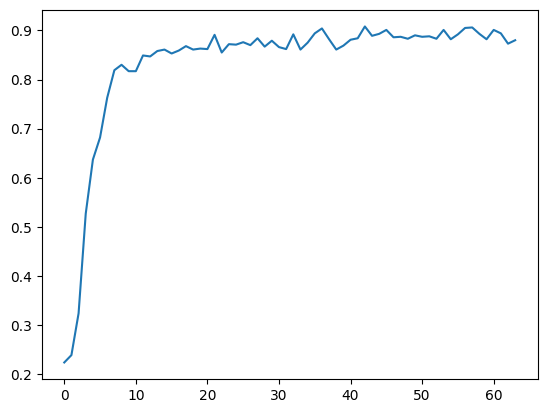

In [47]:
import matplotlib.pyplot as plt
@torch.no_grad
def calc_per_token_acc(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
    ### YOUR CODE STARTS ###
    model.eval()
    per_token_acc = np.zeros(SEQ_LEN)

    for x, y in data_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out = model(x)
        per_token_acc += ((torch.argmax(model_out, dim=-1) == y).to(torch.float32).sum(dim=0)).numpy()

    per_token_acc /= len(data_loader.dataset)
    ###  YOUR CODE ENDS  ###
    return per_token_acc


per_token_acc = calc_per_token_acc(model, TEST_LOADER)
plt.plot(np.arange(per_token_acc.shape[0]), per_token_acc)
plt.show()

On the plot above, it is visible that the accuracy per token increases rapidly for the first few tokens. This suggests that the early tokens in the sequence are crucial for predicting the next token, likely because the model needs to understand the context. Around the 15th token, the accuracy stabilizes and remains above 85%, indicating that the model has acquired sufficient context, and the influence of preceding tokens diminishes.